In [45]:
import tensorflow as tf
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar100

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from keras.utils import np_utils
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi 
import tensorflow as tf
import time
import pandas as pd
import cv2
from sklearn.preprocessing import OneHotEncoder

In [16]:
# # Enable logging of device placement
# tf.debugging.set_log_device_placement(True)

In [17]:

# # Load and preprocess CIFAR-100 data
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Define the class indices for "Vehicles 1"
# vehicles_1_indices = [8, 14, 48, 59, 91]

# # Filter function to select data by specified class indices
# def filter_classes(x_data, y_data, class_indices):
#     mask = np.isin(y_data, class_indices).flatten()
#     return x_data[mask], y_data[mask]

# # Apply the filter function to both training and test sets
# x_train_vehicles, y_train_vehicles = filter_classes(x_train, y_train, vehicles_1_indices)
# x_test_vehicles, y_test_vehicles = filter_classes(x_test, y_test, vehicles_1_indices)

# # Split the training data into training and validation sets
# x_train_vehicles, x_val_vehicles, y_train_vehicles, y_val_vehicles = train_test_split(
#     x_train_vehicles, y_train_vehicles, test_size=0.2, random_state=42
# )

# # Print the sizes of each dataset
# print("Vehicles 1 - Training size:", len(x_train_vehicles))
# print("Vehicles 1 - Validation size:", len(x_val_vehicles))
# print("Vehicles 1 - Test size:", len(x_test_vehicles))

The "Food containers" superclass includes these five classes with their corresponding indices:

Bottle: 10
Bowl: 11
Can: 17
Cup: 29
Plate: 62

In [18]:
# Load CIFAR-100 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the images by scaling pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the class indices for "Aquatic mammals"
aquatic_mammals_indices = [5, 30, 56, 70, 95]

# Filter function to select data by specified class indices
def filter_classes(x_data, y_data, class_indices):
    mask = np.isin(y_data, class_indices).flatten()
    filtered_x = x_data[mask]
    filtered_y = np.array([class_indices.index(label[0]) for label in y_data[mask]])
    return filtered_x, filtered_y

# Apply the filter function to both training and test sets
x_train_vehicles, y_train_vehicles = filter_classes(x_train, y_train, aquatic_mammals_indices)
X_test, y_test = filter_classes(x_test, y_test, aquatic_mammals_indices)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    x_train_vehicles, y_train_vehicles, test_size=0.2, random_state=42
)

# One-hot encode the class labels for training and validation datasets
y_train = to_categorical(y_train, num_classes=len(aquatic_mammals_indices))
y_val = to_categorical(y_val, num_classes=len(aquatic_mammals_indices))
y_test = to_categorical(y_test, num_classes=len(aquatic_mammals_indices))

# Print the sizes of each dataset
print("Vehicles 1 - Training dataset size:", len(X_train))
print("Vehicles 1 - Validation dataset size:", len(X_val))
print("Vehicles 1 - Test dataset size:", len(X_test))

Vehicles 1 - Training dataset size: 2000
Vehicles 1 - Validation dataset size: 500
Vehicles 1 - Test dataset size: 500


In [19]:
X_train.shape

(2000, 32, 32, 3)

In [20]:
# # Usage
# preprocessor = CNNDataPreprocessor()
# X_train, y_train, X_val, y_val, X_test, y_test = preprocessor.load_data()

In [21]:
# Define reduction percentages
reduction_percentage = 0.4

# Reduce the size of the datasets
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [22]:
X_train.shape , X_val.shape, X_test.shape

((1200, 32, 32, 3), (300, 32, 32, 3), (300, 32, 32, 3))

In [23]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_cnn(self, input_shape, num_classes, optimizer):
        """Build a CNN model compatible with CIFAR-10 data."""
        self.model = Sequential()
        self.model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(120, activation='relu'))
        self.model.add(Dense(84, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [24]:
# # Load the CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Normalize images to range [0, 1]
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Split the training set into training and validation sets
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [25]:
# # Print shapes to verify splits
# print("Training Set: ", x_train.shape, y_train.shape)
# print("Validation Set: ", x_val.shape, y_val.shape)
# print("Test Set: ", x_test.shape, y_test.shape)

In [26]:
# # One-hot encoding of the labels
# num_classes = 10
# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [27]:
# x_train.shape

In [28]:
(x_train.shape[1], x_train.shape[2],x_train.shape[3])

(32, 32, 3)

In [30]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    # neural_network_model.build_ann(input_shape=(X_train.shape[1], X_train.shape[2]), optimizer=optimizer)
    neural_network_model.build_cnn(input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]), num_classes=5, optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
38/38 [==============================] - 1s 18ms/step - loss: 1.6088 - accuracy: 0.1892 - val_loss: 1.5845 - val_accuracy: 0.2733 - lr: 0.0100
Epoch 2/50
38/38 [==============================] - 0s 10ms/step - loss: 1.5561 - accuracy: 0.3175 - val_loss: 1.5150 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 1.4224 - accuracy: 0.3958 - val_loss: 1.4706 - val_accuracy: 0.3033 - lr: 0.0100
Epoch 4/50
38/38 [==============================] - 0s 6ms/step - loss: 1.2572 - accuracy: 0.4475 - val_loss: 1.2843 - val_accuracy: 0.3867 - lr: 0.0100
Epoch 5/50
38/38 [==============================] - 0s 6ms/step - loss: 1.1812 - accuracy: 0.4833 - val_loss: 1.0999 - val_accuracy: 0.5100 - lr: 0.0100
Epoch 6/50
38/38 [==============================] - 0s 6ms/step - loss: 1.1094 - accuracy: 0.5267 - val_loss: 1.0345 - val_accuracy: 0.5700 - lr: 0.0100
Epoch 7/50
38/38 [=========================

In [31]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.6500, Precision - 0.6492, Recall - 0.6500, F1-score - 0.6471, Convergence Speed - 46 epochs, Training Time - 12.45 seconds
SGD_momentum: Test Accuracy - 0.6900, Precision - 0.6943, Recall - 0.6900, F1-score - 0.6887, Convergence Speed - 20 epochs, Training Time - 5.58 seconds
Nesterov: Test Accuracy - 0.7133, Precision - 0.7140, Recall - 0.7133, F1-score - 0.7099, Convergence Speed - 28 epochs, Training Time - 7.27 seconds
RMSprop: Test Accuracy - 0.7433, Precision - 0.7482, Recall - 0.7433, F1-score - 0.7436, Convergence Speed - 36 epochs, Training Time - 11.39 seconds
Adagrad: Test Accuracy - 0.6167, Precision - 0.6162, Recall - 0.6167, F1-score - 0.6151, Convergence Speed - 50 epochs, Training Time - 12.76 seconds
Adadelta: Test Accuracy - 0.2667, Precision - 0.3166, Recall - 0.2667, F1-score - 0.2267, Convergence Speed - 50 epochs, Training Time - 12.80 seconds
Adam: Test Accuracy - 0.7767, Precision - 0.7765, Recall - 0.7767, F1-score - 0.7759, Con

In [33]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Aquatic mammals"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["CNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Aquatic mammals,1200,32,float32,CNN,SGD,0.650000,0.649221,0.650000,0.647125,46,12.449574,1.608842,1.584503
1,Aquatic mammals,1200,32,float32,CNN,SGD_momentum,0.690000,0.694327,0.690000,0.688689,20,5.578527,1.425587,1.331133
2,Aquatic mammals,1200,32,float32,CNN,Nesterov,0.713333,0.713975,0.713333,0.709880,28,7.265174,1.502383,1.802368
3,Aquatic mammals,1200,32,float32,CNN,RMSprop,0.743333,0.748176,0.743333,0.743622,36,11.388428,1.379714,1.081847
4,Aquatic mammals,1200,32,float32,CNN,Adagrad,0.616667,0.616211,0.616667,0.615100,50,12.761535,1.620451,1.607689
5,Aquatic mammals,1200,32,float32,CNN,Adadelta,0.266667,0.316613,0.266667,0.226691,50,12.800870,1.609629,1.610578
6,Aquatic mammals,1200,32,float32,CNN,Adam,0.776667,0.776455,0.776667,0.775945,37,9.911590,1.494208,1.269704
7,Aquatic mammals,1200,32,float32,CNN,AMSGrad,0.713333,0.719866,0.713333,0.713997,19,5.743572,1.494879,1.176127
8,Aquatic mammals,1200,32,float32,CNN,AdamW,0.730000,0.732230,0.730000,0.730043,50,13.815152,1.290684,1.051180
9,Aquatic mammals,1200,32,float32,CNN,Yogi,0.663333,0.676444,0.663333,0.653038,22,11.597512,1.313802,1.218966


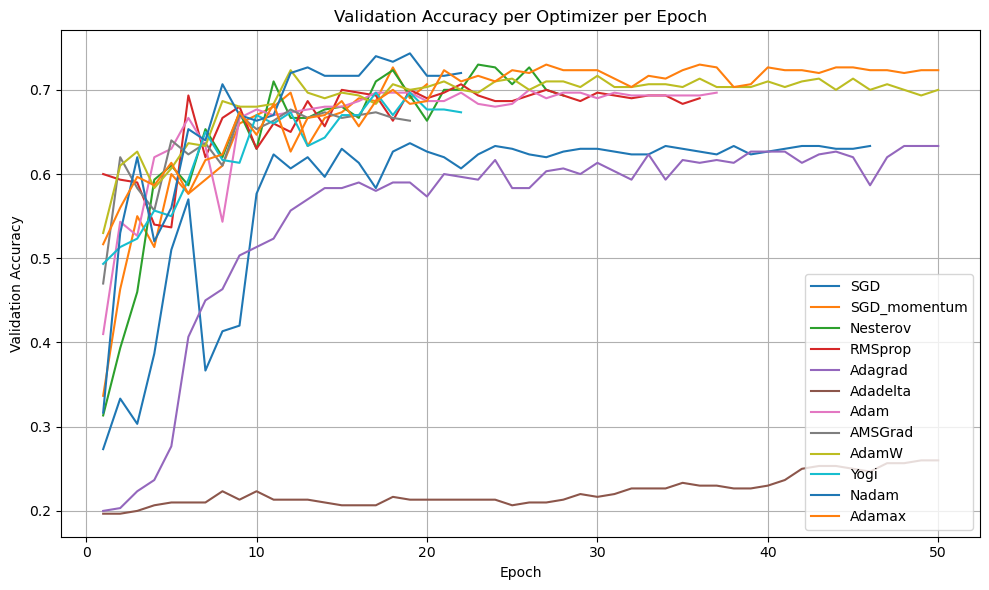

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


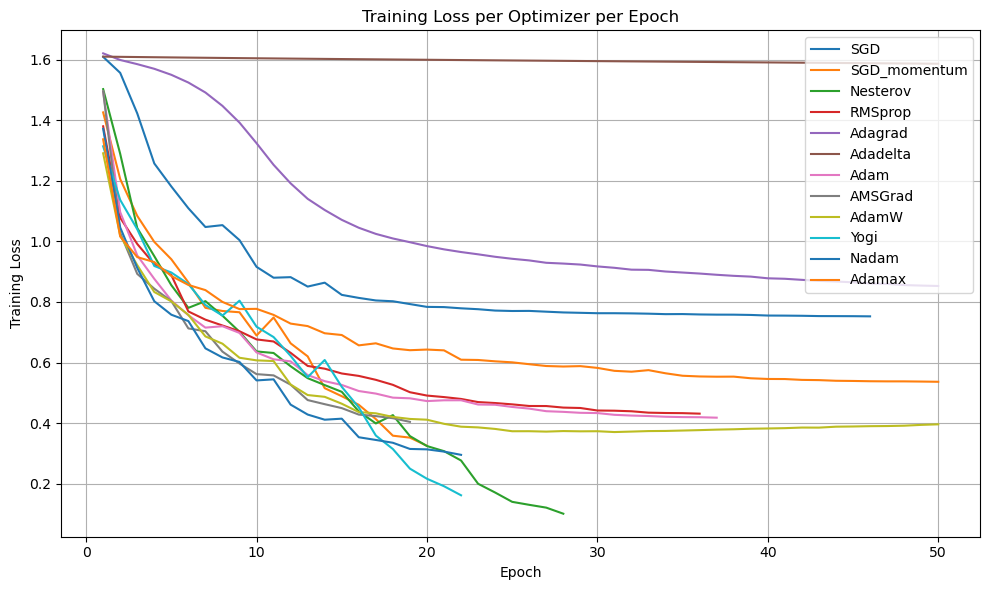

In [36]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
final_df.to_csv('Aquatic-mammals', index=False)